# Ray Tracing in One Weekend
An attempt in Python

Based on: https://raytracing.github.io/books/RayTracingInOneWeekend.html


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math as m

## Output an Image

height: 100%|██████████| 256/256 [00:01<00:00, 128.51it/s]


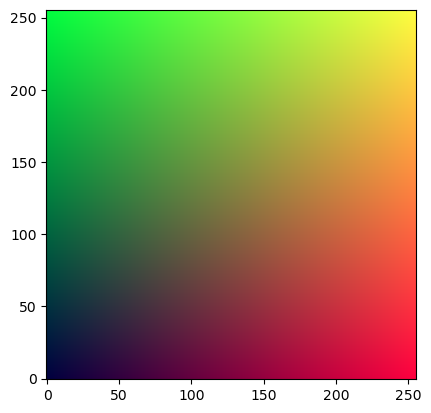

In [2]:
image_width = 256
image_height = 256

image = np.zeros( (image_width,image_height,3), dtype=np.uint8)
for j in tqdm(range(image_height), desc="height", position=0):
    for i in tqdm(range(image_width), desc="width", position=1, leave=False):
        r = i / (image_width - 1)
        g = j / (image_height - 1)
        b = 0.25

        ir = int(255.999 * r)
        ig = int(255.999 * g)
        ib = int(255.999 * b)

        image[i, j, :] = np.asarray([ir, ig, ib])

plt.imshow(image.transpose(1,0,2), origin='lower')

## Vector Class

In [3]:
class Vector:
    def __init__(self, x: float = 0, y: float = 0, z: float = 0) -> None:
        self.x = x
        self.y = y
        self.z = z
        self._as_np = np.asarray([x, y, z])
        self.length = np.linalg.norm(self._as_np)

    @classmethod
    def _from_np(cls, nparr):
        return cls(x=nparr[0], y=nparr[1], z=nparr[2])

    def to_np(self):
        return self._as_np

    def __neg__(self):
        return Vector(-self.x, -self.y, -self.z)

    def __getitem__(self, key):
        return self._as_np[key]

    def __repr__(self):
        return f'{self.x}, {self.y}, {self.z}'

    def __add__(self, other):
        return self._from_np(self._as_np + other._as_np)

    def __sub__(self, other):
        return self._from_np(self._as_np - other._as_np)

    def __mul__(self, other: float):
        return self._from_np(self._as_np * other)

    def __truediv__(self, other):
        return self._from_np(self._as_np * (1/other))

def dot(v1: Vector, v2: Vector) -> float:
    return np.dot(v1._as_np, v2._as_np)

def cross(v1: Vector, v2: Vector) -> Vector:
    return Vector._from_np(np.cross(v1._as_np, v2._as_np))
        
def unit_vector(vec: Vector) -> Vector:
    return vec / vec.length

# Type Aliases for Vector
Point = Vector
Color = Vector

height: 100%|██████████| 256/256 [00:02<00:00, 95.67it/s] 


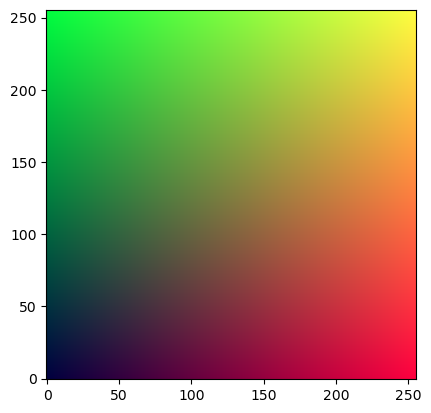

In [4]:
def write_color(pixel_color: Color) -> np.array:
    return (255.999 * pixel_color.to_np()).astype(int)

image = np.zeros( (image_width,image_height,3), dtype=np.uint8)
for j in tqdm(range(image_height), desc="height", position=0):
    for i in tqdm(range(image_width), desc="width", position=1, leave=False):
        image[i, j, :] = write_color(Color(i / (image_width - 1), j / (image_height - 1), 0.25))

plt.imshow(image.transpose(1,0,2), origin='lower')

## Rays, Camera, Background

height: 100%|██████████| 225/225 [00:10<00:00, 21.02it/s]


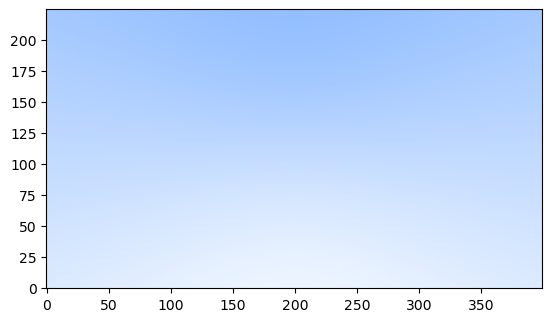

In [5]:
class Ray:
    def __init__(self, origin: Point, direction: Vector) -> None:
        self.origin = origin
        self.direction = direction

    def at(self, t) -> Point:
        return self.origin + (self.direction*t)

def ray_color(ray: Ray) -> Color:
    unit_direction: Vector = unit_vector(ray.direction)
    t = 0.5 * (unit_direction[1] + 1.0)
    return (Color(1,1,1)*(1.0-t)) + (Color(0.5, 0.7, 1.0)*t)


def main():
    aspect_ratio = 16.0 / 9.0
    image_width = 400
    image_height = int(image_width / aspect_ratio)

    viewport_height = 2.0
    viewport_width = aspect_ratio * viewport_height
    focal_length = 1.0

    origin = Point(0,0,0)
    horizontal = Vector(viewport_width, 0, 0)
    vertical = Vector(0, viewport_height, 0)
    lower_left_corner = origin - (horizontal/2) - (vertical/2) - Vector(0,0,focal_length)

    image = np.zeros( (image_width,image_height,3), dtype=np.uint8)
    for j in tqdm(range(image_height), desc="height", position=0):
        for i in tqdm(range(image_width), desc="width", position=1, leave=False):
            u = i / (image_width - 1)
            v = j / (image_height - 1)

            ray = Ray(origin, lower_left_corner + (horizontal*u) + (vertical*v) - origin)
            image[i, j, :] = write_color(ray_color(ray))

    plt.imshow(image.transpose(1,0,2), origin='lower')

main()

## Spherical

height: 100%|██████████| 225/225 [00:13<00:00, 16.73it/s]


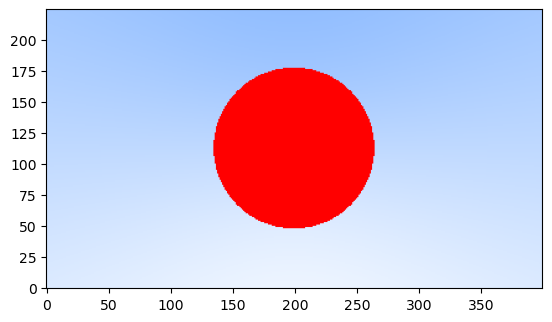

In [6]:
def hit_sphere(center: Point, radius: float, ray: Ray) -> bool:
    oc: Vector = ray.origin - center
    a = dot(ray.direction, ray.direction)
    b = 2.0 * dot(oc, ray.direction)
    c = dot(oc, oc) - pow(radius, 2)
    discriminant = pow(b, 2) - (4*a*c)
    return discriminant > 0

def ray_color(ray: Ray):
    if hit_sphere(Point(0,0,-1), 0.5, ray):
        return Color(1,0,0)
    
    unit_direction: Vector = unit_vector(ray.direction)
    t = 0.5 * (unit_direction.y + 1.0)
    return (Color(1,1,1)*(1.0-t)) + (Color(0.5, 0.7, 1.0)*t)

main()

## Normals and Multiple Objects

height: 100%|██████████| 225/225 [00:14<00:00, 15.88it/s]


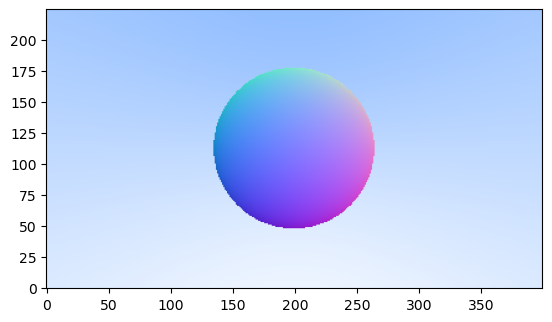

In [22]:
def hit_sphere(center: Point, radius: float, ray: Ray) -> float:
    oc = ray.origin - center
    a = dot(ray.direction, ray.direction)
    b = 2.0 * dot(oc, ray.direction)
    c = dot(oc, oc) - pow(radius, 2)
    discriminant = pow(b, 2) - (4*a*c)
    if discriminant < 0:
        return -1
    else:
        return (-b - m.sqrt(discriminant)) / (2*a)

def unit_vector(v):
    return v / np.linalg.norm(v)

def ray_color(ray: Ray):
    t = hit_sphere(Point(0,0,-1), 0.5, ray)
    if t > 0:
        n = (ray.at(t) - Vector(0,0,-1)) / (ray.at(t) - Vector(0,0,-1)).length
        return (Color(n.x+1, n.y+1, n.z+1)) * 0.5
    
    unit_direction: Vector = ray.direction / ray.direction.length
    t = (unit_direction[1] + 1.0) * 0.5
    return (Color(1,1,1)*(1-t)) + (Color(0.5, 0.7, 1.0)*t)


main()

height: 100%|██████████| 225/225 [00:16<00:00, 13.55it/s]


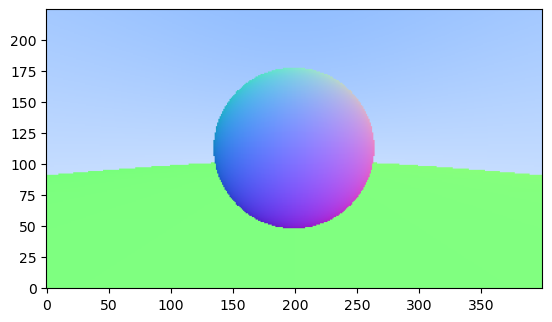

In [40]:
from abc import ABC, abstractmethod
from math import radians

class HitRecord:
    def __init__(self) -> None:
        self.p: Point 
        self.normal: Vector
        self.t: float
        self.front_face: bool

    def set_face_normal(self, r: Ray, outward_normal: Vector):
        front_face = dot(r.direction, outward_normal) < 0
        self.normal =  outward_normal if front_face else -outward_normal

class Hittable(ABC):
    @abstractmethod
    def hit(r: Ray, t_min: float, t_max: float, rec: HitRecord) -> bool:
        return 0

class Sphere(Hittable):
    def __init__(self, cen: Point, r: float) -> None:
        super().__init__()
        self.center = cen
        self.radius = r

    def hit(self, r: Ray, t_min: float, t_max: float, rec: HitRecord) -> bool:
        oc = r.origin - self.center
        a = pow(r.direction.length, 2)
        half_b = dot(oc, r.direction)
        c = pow(oc.length, 2) - pow(self.radius, 2)

        discriminant = pow(half_b, 2) - (a * c)
        if discriminant < 0:
            return False

        sqrtd = m.sqrt(discriminant)

        root = (-half_b - sqrtd) / a
        if (root < t_min) or (t_max < root):
            root = (-half_b + sqrtd) / a
            if (root < t_min) or (t_max < root):
                return False

        rec.t = root
        rec.p = r.at(rec.t)
        outward_normal = (rec.p - self.center) / self.radius
        rec.set_face_normal(r, outward_normal)

        return True


class HittableList(Hittable):
    def __init__(self) -> None:
        super().__init__()
        self.objects: list[Hittable] = []

    def add(self, object):
        self.objects.append(object)

    def clear(self):
        self.objects.clear()

    def hit(self, r: Ray, t_min: float, t_max: float, rec: HitRecord) -> bool:
        hit_anything = False
        closest_so_far = t_max

        for i in self.objects:
            if i.hit(r, t_min, closest_so_far, rec):
                hit_anything = True
                closest_so_far = rec.t
                # rec = i.hit_record

        return hit_anything


def ray_color(ray: Ray, world: Hittable):
    rec = HitRecord()
    if world.hit(ray, 0, m.inf, rec):
        return (rec.normal + Color(1,1,1)) * 0.5

    unit_direction: Vector = ray.direction / ray.direction.length
    t = 0.5 * (unit_direction.y + 1.0)
    return (Color(1,1,1)*(1.0-t)) + (Color(0.5, 0.7, 1.0)*t)


def main():
    aspect_ratio = 16.0 / 9.0
    image_width = 400
    image_height = int(image_width / aspect_ratio)

    world = HittableList()
    world.add(Sphere(Point(0,0,-1), 0.5))
    world.add(Sphere(Point(0,-100.5,-1), 100))

    viewport_height = 2.0
    viewport_width = aspect_ratio * viewport_height
    focal_length = 1.0

    origin = Point(0,0,0)
    horizontal = Vector(viewport_width, 0, 0)
    vertical = Vector(0, viewport_height, 0)
    lower_left_corner = origin - (horizontal/2) - (vertical/2) - Vector(0,0,focal_length)

    image = np.zeros( (image_width,image_height,3), dtype=np.uint8)
    for j in tqdm(range(image_height), desc="height", position=0):
        for i in tqdm(range(image_width), desc="width", position=1, leave=False):
            u = i / (image_width - 1)
            v = j / (image_height - 1)

            ray = Ray(origin, lower_left_corner + (horizontal*u) + (vertical*v) - origin)
            image[i, j, :] = write_color(ray_color(ray, world))

    plt.imshow(image.transpose(1,0,2), origin='lower')

main()